### Linear Regression Basics

To get a better sense of what's going on with linear regression, let's build up things step by step.  We can continue with our biomass prediction example discussed last class. First, let's load some basic libraries and data.  I'm using the seaborn library, which works with matplotlib, to make plots look nicer.  This is based on Chapter 7 of the Machine Learning book by Peter Flach.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
sns.set()

# Load the file into a pandas dataframe
df_all = pd.read_csv("biomass_predictors_continuous.csv")
# Remove all the cases where our predictor is zero
df_all = df_all[df_all["HEIGHT"]>0]
# Randomize the order
df_all = df_all.sample(frac=1.0, random_state=0)
# Get the first 10,000 records, as a sample to play with.
data = df_all[:10000]

In [2]:
data.head()

,HEIGHT,PCT_TREE,NDVI_DELTA,NPP,PRECIP_ANN,TEMP_MEAN,TEMP_SDEV,PRECIP_CV,CTI,ELEV,LC_TYPE,X,Y,NCBD_30M
10456,24,56,-0.02013,9211,1649,99,4763,59,436,183,5,-123.209143,46.563999,163.0
511,21,8,-0.00270,1594,642,19,5453,64,388,3102,7,-118.832434,37.133285,175.0
7111,24,79,-0.03464,6791,904,77,8865,22,362,549,4,-77.100061,41.462784,184.0
20334,9,28,0.01924,5395,1316,208,6004,30,1078,2,8,-95.473854,28.918147,44.0
12774,12,2,-0.03473,3815,995,118,9723,27,612,245,12,-91.750121,39.158745,0.0


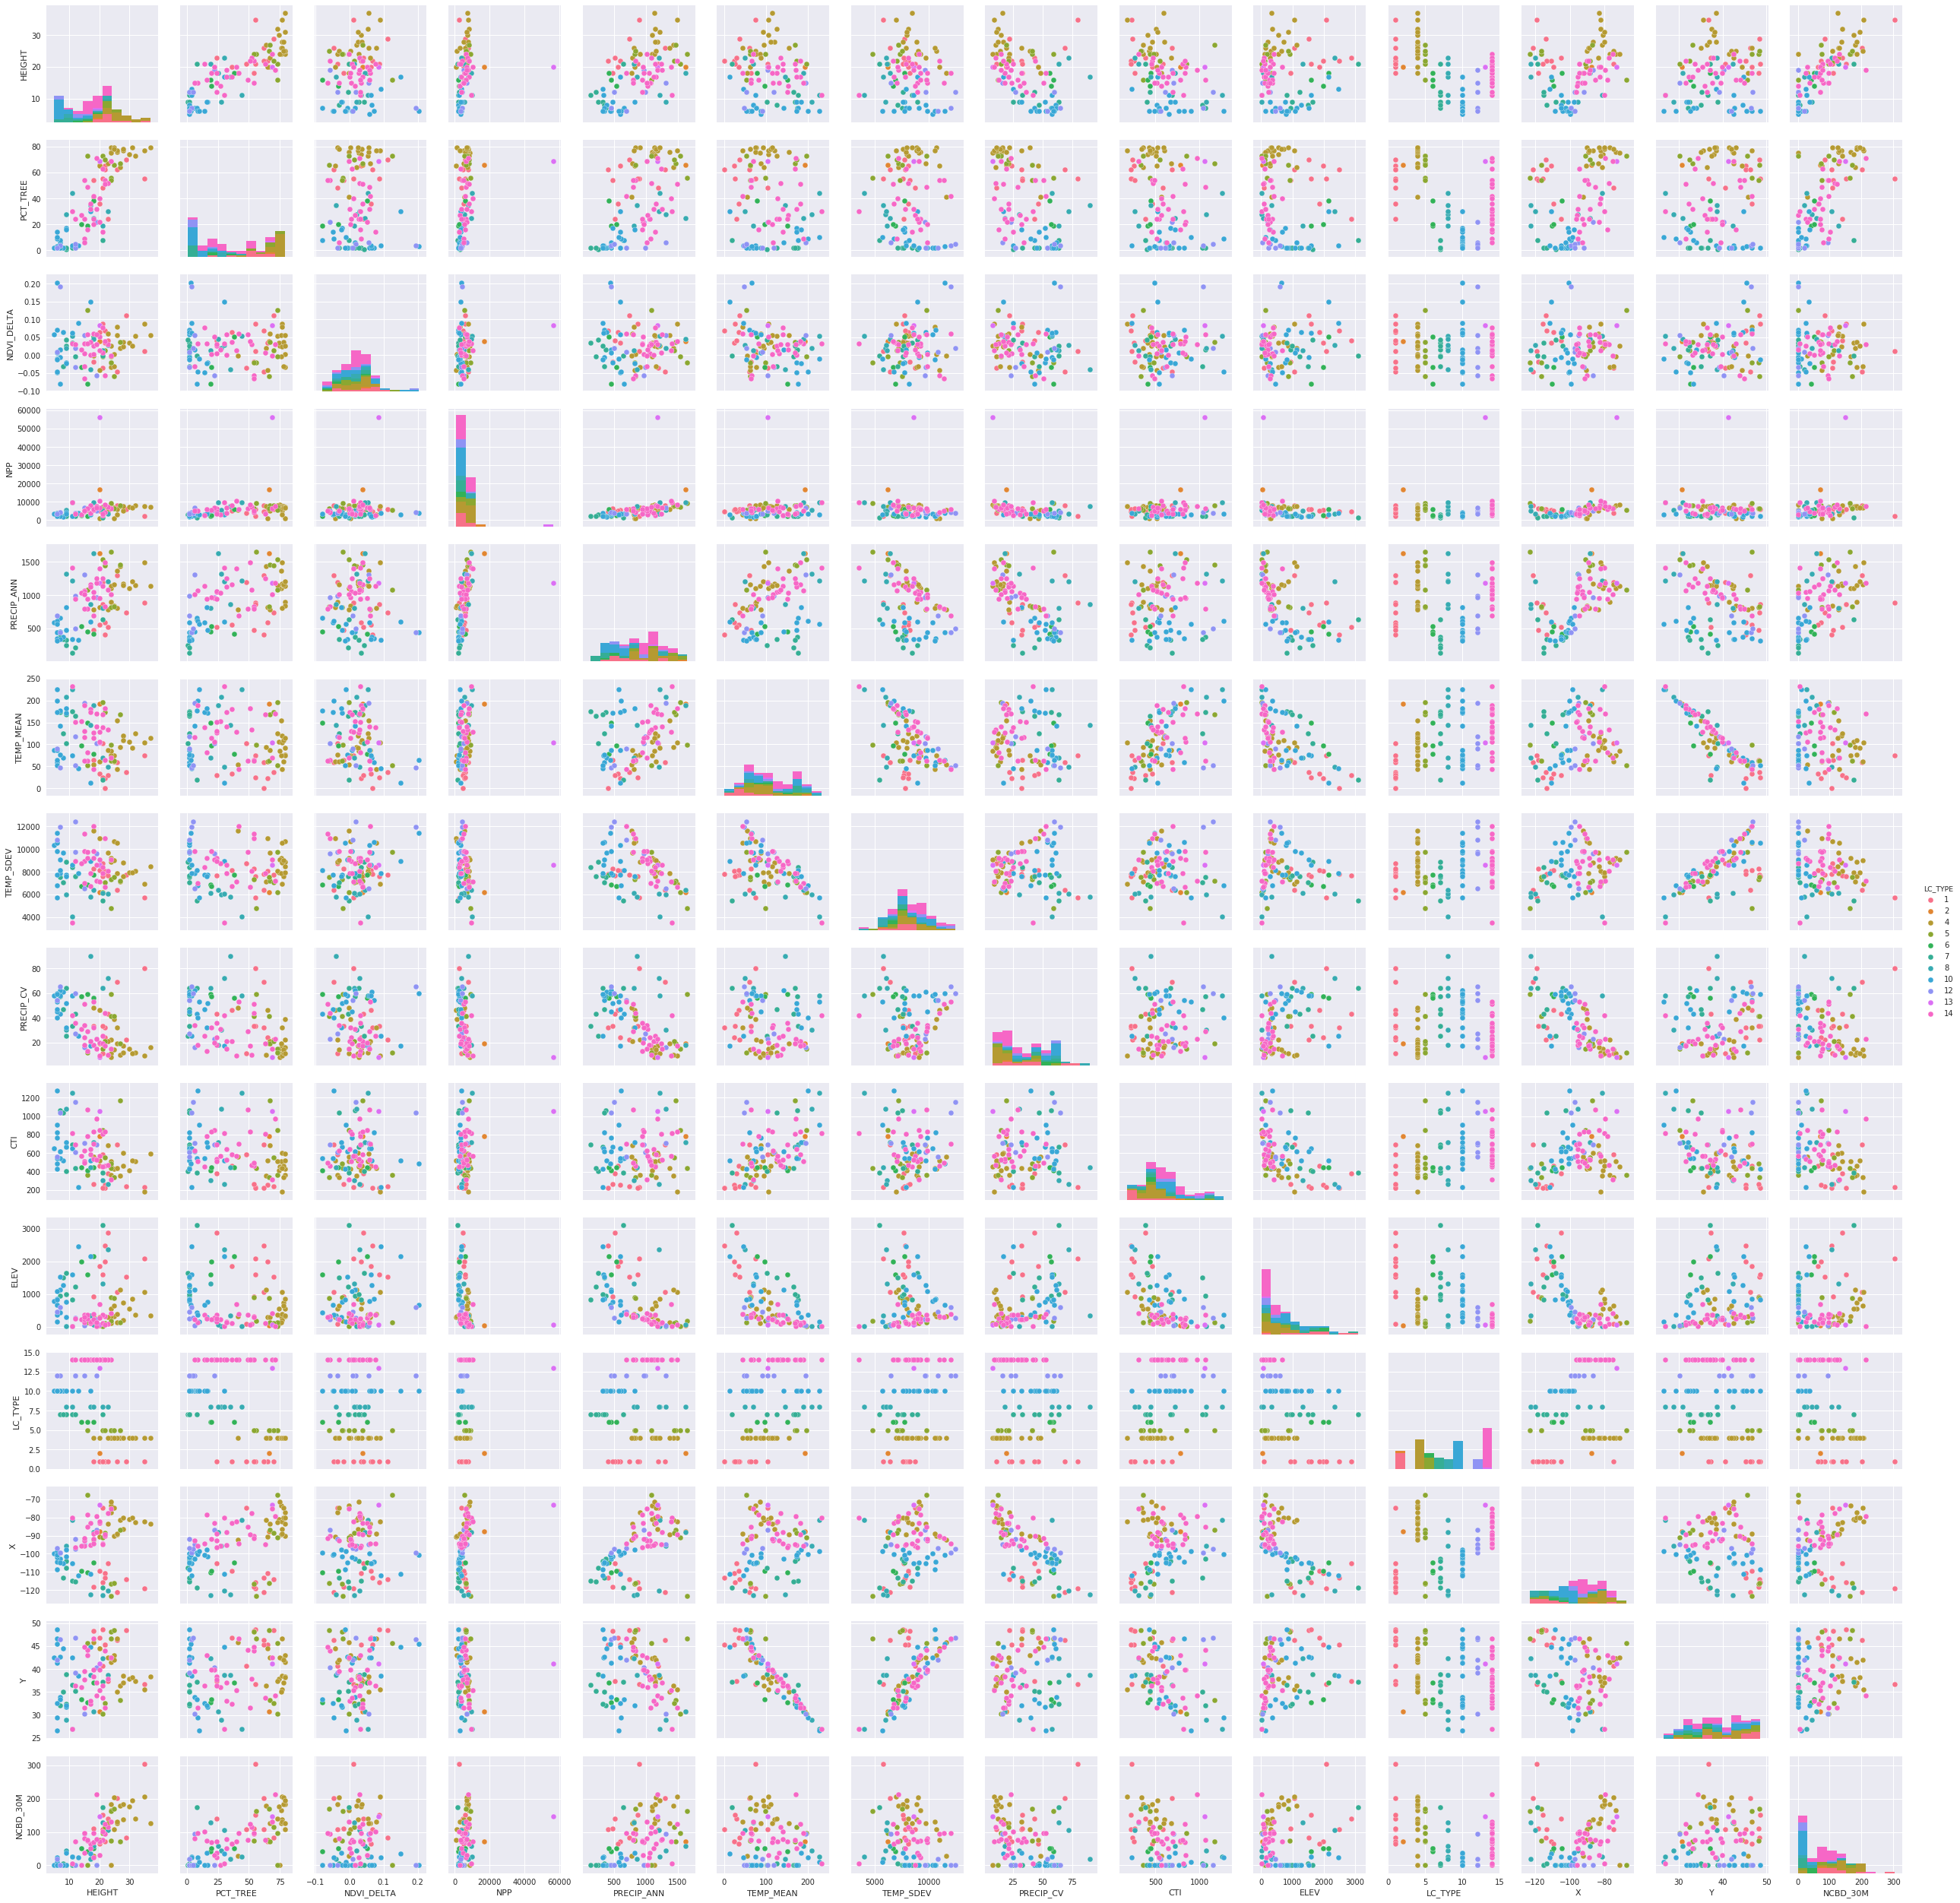

In [14]:
sns.pairplot(data[:100], hue='LC_TYPE', size=2.5);

We can see that from looking at the data above, that height and percent tree are both related to biomass, and are correlated with eachother. Let's start simple by building a linear model between tree height and biomass.

In [108]:
# The thing we are trying to predict is the biomass at 30 m resolution,
# which is in the NCBD_30M column (National Carbon and Biomass Database)
y_train = data["NCBD_30M"].values
x_train_1d = data["HEIGHT"].values
x_train_2d = data.iloc[:, 0:1].values

y_train is the training data for the value we are trying to predict with our model; x_train_1d is a 1-dimensional array of independent variables, i.e., predictors. Many prediction methods assume there are multiple predictors, so for convenience I loaded the same data into x_train_2d, a 2-dimensional array with 10,000 rows and 1 column:

In [109]:
print(y_train.shape)
print(x_train_1d.shape)
print(x_train_2d.shape)

(10000,)
(10000,)
(10000, 1)


Here's a look at the scatterplot for that one predictor variable

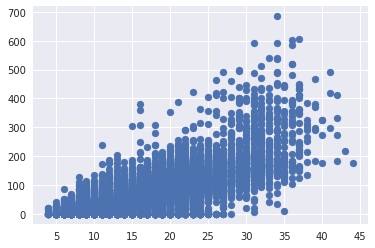

In [110]:
x = x_train_1d
y = y_train
plt.scatter(x, y)
plt.show()

One way of thinking of a linear model is that we are looking for the slope and intercept of the line that goes through the middle of the data.  Slope in this context is defined as the change in y over the change in x. 

One might be tempted to take a rough guess this way, just by inspection you can see that the biomass is about four times the height:

In [213]:
y.mean() / x.mean()

-5.2985418105035139e-16

Almost as intuitively, but more accurately, we can think of the slope of the line as the ratio between the variability in x and y, over the variability in x, or, the covaraiance between x and y divided or normalized by the variance in x:

In [214]:
# Calculate covariance between x and y
def covariance(x, mean_x, y, mean_y):
    covar = 0.0
    for i in range(len(x)):
        covar += (x[i] - mean_x) * (y[i] - mean_y)
    return covar

# Calculate the variance of a list of numbers
def variance(values, mean):
    return sum([(x-mean)**2 for x in values])

b1 = covariance(x, x.mean(), y, y.mean()) / variance(x, x.mean())
print(b1)

7.7874124475


Which gives us our b[1] or m term (y = mx + b, or more generally, y = b[0] + b[1]x), and our intercept or b[0], is simply:

In [215]:
b0 = y.mean() - b1 * x.mean()

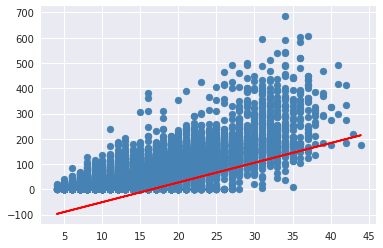

In [216]:
x = x_train_1d
y = y_train
plt.scatter(x, y, color='steelblue')
plt.plot(x, b0 + b1 * x, color='red')
plt.show()

One way to simplify this by zero centering it, so the b1 parameter is simply (x * y) / v:

In [217]:
x = x_train_1d - x_train_1d.mean()
print(x)
print(x.mean())
print(x.std())
y = y_train - y_train.mean()
print(y)
print(y.mean())
v = (x ** 2).sum()
print(v)
print((y * x).sum() / v)

[ 7.5216  4.5216  7.5216 ..., -9.4784  7.5216  7.5216]
-5.59907675779e-16
7.49612789645
[  95.4138  107.4138  116.4138 ...,  -67.5862   75.4138   29.4138]
-8.73114913702e-15
561919.3344
7.7874124475


Now we can look at this same approach, estimating the value of y based on the variance and covariance between zero-centered x and y in a more generalizable form using matrix notation.

So, in this case X is now our predictor matrix.  Let's play around with this to get a sense of what this means:

In [218]:
x = x_train_1d
X = x - x.mean()
print(X)
print(X.T)
print(np.dot(X.T, X)) 
print((X ** 2).sum())

[ 7.5216  4.5216  7.5216 ..., -9.4784  7.5216  7.5216]
[ 7.5216  4.5216  7.5216 ..., -9.4784  7.5216  7.5216]
561919.3344
561919.3344


In [219]:
X = x_train_1d - x_train_1d.mean()
Y = y_train - y_train.mean()
v = np.dot(X.T, X)
print(np.dot(X, y) / v)

7.7874124475


Now, let's check in with a reference to make sure we're on the same page:

In [220]:
regr = linear_model.LinearRegression()
regr.fit(x_train_2d - x_train_2d.mean(), Y)
print(regr.coef_)

[ 7.78741245]


Now, it becomes easier to extend this to multiple predictors:

In [221]:
y_m = data["NCBD_30M"].values
x_m = data.iloc[:, 0:2].values

In [222]:
X = x_m - x_m.mean(axis=0)
Y = y_m - y_m.mean()
c = np.dot(X.T, y)
v = np.dot(X.T, X)
vi = np.linalg.inv(v)
coef = np.dot(vi, c)
print(coef)

[ 7.61132511  0.05514513]


Ok, let's check our work again:

In [223]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print(regr.coef_)

[ 7.61132511  0.05514513]


Now, another way of thinking of what's going on here is that we are optimizing weights for each of our predictors:

$$y_i = h(x_i, \mathbf{w}) = \mathbf{w}^Tx_i$$

Which means minimizing a loss function for our possible weights, the squared error:

$$L(\mathbf{w}) = \sum_i (h(x_i,\mathbf{w})-y_i)^2$$

Summarized from: http://briandolhansky.com/blog/artificial-neural-networks-linear-regression-part-1

This brings us to another algorithm, the perceptron, which learns weights by iteratively adjusting their value based on individual observations:

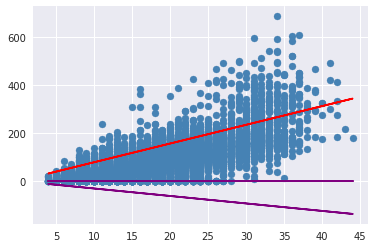

7.7874124475 -2.34312906855e-16


In [224]:
plt.scatter(x_train_1d, y_train, color='steelblue')
X = x_train_1d - x_train_1d.mean() # (x_train_1d - x_train_1d.mean()) / x_train_1d.std()
Y = y_train - y_train.mean()
m_current = 0
b_current = 0
epochs = 3000
learning_rate = 0.0001
N = float(len(y))
for i in range(epochs):
    y_current = (m_current * X) + b_current
    loss = sum([data ** 2 for data in (y - y_current)]) / N
    m_gradient = -(2 / N) * sum(X * (y - y_current))
    b_gradient = -(2 / N) * sum(y - y_current)
    m_current = m_current - (learning_rate * m_gradient)
    b_current = b_current - (learning_rate * b_gradient)
    if (i + 1) % 500 == 0:
        plt.plot(x_train_1d, b_current + m_gradient * x_train_1d, color='purple')
plt.plot(x_train_1d, b_current + m_current * x_train_1d, color='red')
plt.show()
print(m_current, b_current)

There are two important characteristics introduced by this example:

**First**, it builds a model estimates based on the value of individual training samples. This can also be used for classification, as in support vector machine classifiers, where, instead of basing the class decision boundary on all examples, the boundary is derived from the examples closest to the decision boundary, or the **support vectors**.

**Second**, it builds the model heuristically from the data.  This allows for the model to potentially accommodate more complex, non-linear relationships.  The basic perceptron algorithm has node for each predictor attribute; by instead constructing layers of perceptrons, where each layer can feed into another, complex relationships between predictors can be modeled.

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

[[ 6.80769231]]


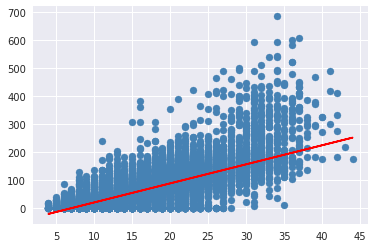

In [230]:
from sklearn.svm import SVR
X = x_train_2d
y = y_train
svr = SVR(kernel='linear', C=1.0)
svr.fit(X, y)
print(svr.coef_)
plt.scatter(x_train_1d, y_train, color='steelblue')
plt.plot(x_train_1d, svr.predict(X), color='red', label='Linear model')
plt.show()

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

/home/gtech733/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


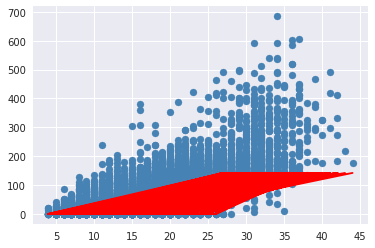

In [236]:
from sklearn.linear_model import Perceptron
X = x_train_2d
y = y_train
per = Perceptron()
per.fit(X, y)
pred = per.predict(X)
plt.scatter(x_train_1d, y_train, color='steelblue')
plt.plot(x_train_1d, pred, color='red', label='Linear model')
plt.show()

http://scikit-learn.org/stable/modules/neural_networks_supervised.html
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

In [235]:
pred.shape

(10000,)

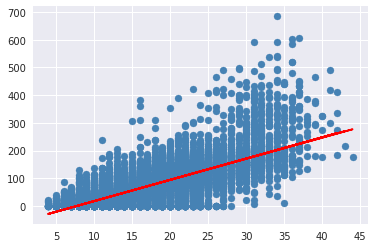

1


In [242]:
from sklearn.neural_network import MLPRegressor

X = x_train_2d
y = y_train
per = MLPRegressor()
per.fit(X, y)
pred = per.predict(X)
plt.scatter(x_train_1d, y_train, color='steelblue')
plt.plot(x_train_1d, pred, color='red', label='Linear model')
plt.show()
